In [26]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [27]:
dataraw = pd.read_csv("HW1_Raw.csv")
dataraw.columns = ["PERMNO", "Date", "DeclDate", "PayDate", "RecDate", "DistCode", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]
dataraw

,PERMNO,Date,DeclDate,PayDate,RecDate,DistCode,DivAmount,Price,Volume,HolPerReturn,MarketReturn
0,11850,20000103,NaN,NaN,NaN,NaN,NaN,78.1875,6728599,-0.029480,-0.006803
1,11850,20000104,NaN,NaN,NaN,NaN,NaN,76.8125,7255399,-0.017586,-0.039652
2,11850,20000105,NaN,NaN,NaN,NaN,NaN,81.0000,8742500,0.054516,-0.000935
3,11850,20000106,NaN,NaN,NaN,NaN,NaN,85.0000,9730699,0.049383,-0.007391
4,11850,20000107,NaN,NaN,NaN,NaN,NaN,84.9375,8302799,-0.000735,0.032516
...,...,...,...,...,...,...,...,...,...,...,...
5279,11850,20201224,NaN,NaN,NaN,NaN,NaN,41.6000,8039006,-0.004070,0.002332
5280,11850,20201228,NaN,NaN,NaN,NaN,NaN,41.7400,23877548,0.003365,0.003870
5281,11850,20201229,NaN,NaN,NaN,NaN,NaN,41.2700,20287740,-0.011260,-0.003649
5282,11850,20201230,NaN,NaN,NaN,NaN,NaN,41.6000,23807314,0.007996,0.003281


In [28]:
dataraw["Date"] = pd.to_datetime(dataraw["Date"], format='%Y%m%d')
dataraw["DeclDate"] = pd.to_datetime(dataraw["DeclDate"], format='%Y%m%d')
dataraw["PayDate"] = pd.to_datetime(dataraw["PayDate"], format='%Y%m%d')
dataraw["RecDate"] = pd.to_datetime(dataraw["RecDate"], format='%Y%m%d')
data = dataraw.loc[:,["Date", "DeclDate", "PayDate", "RecDate", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()

In [29]:
data

,Date,DeclDate,PayDate,RecDate,DivAmount,Price,Volume,HolPerReturn,MarketReturn
0,2000-02-09,2000-01-26,2000-03-10,2000-02-11,0.44,76.0625,6204000,-0.030847,-0.017185
1,2000-05-11,2000-04-26,2000-06-10,2000-05-15,0.44,82.9375,5487199,0.023037,0.020428
2,2000-08-10,2000-07-26,2000-09-11,2000-08-14,0.44,81.9375,3496099,0.013877,-0.009367
3,2000-11-09,2000-10-25,2000-12-11,2000-11-13,0.44,89.8750,5323199,-0.004108,-0.009808
4,2001-02-07,2001-01-31,2001-03-09,2001-02-09,0.44,84.3600,5812400,0.005454,-0.008672
...,...,...,...,...,...,...,...,...,...
81,2019-11-08,2019-10-30,2019-12-10,2019-11-12,0.87,70.7700,12107599,-0.018765,0.002641
82,2020-02-10,2020-01-29,2020-03-10,2020-02-11,0.87,59.9600,20934456,-0.010412,0.006756
83,2020-05-12,2020-04-29,2020-06-10,2020-05-13,0.87,44.1200,25439095,-0.016397,-0.020370
84,2020-08-12,2020-07-29,2020-09-10,2020-08-13,0.87,44.0900,22508884,-0.000222,0.012996


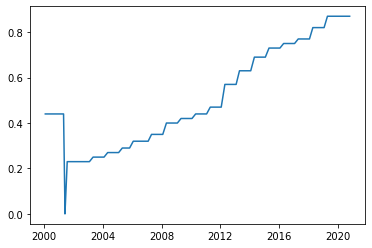

In [37]:
plt.plot(data["DeclDate"], data["DivAmount"])